In [9]:
import diffrax
import jax
import ticktack
import matplotlib.pyplot as pyplot

In [10]:
parameters = (774.86, 0.25, 0.8, 6.44)

In [11]:
model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

STEADY_PROD = model.equilibrate(target_C_14=707.)
STEADY_STATE = model.equilibrate(production_rate=STEADY_PROD)
PROD_COEFFS = model._production_coefficients
MATRIX = model._matrix
GROWTH = model
del model

In [12]:
@jax.tree_util.Partial
@jax.jit
def production(t, args):
    start_time, duration, phase, area = jax.numpy.array(args)
    middle = start_time + duration / 2.
    height = area / duration

    gauss = height * jax.numpy.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)
    sine = 1.8803862513018528 + 0.18 * 1.8803862513018528 *\
        jax.numpy.sin(2 * jax.numpy.pi / 11 * t + phase * 2 * jax.numpy.pi / 11) 
        
    return (sine + gauss) * 3.747273140033743

In [13]:
@jax.tree_util.Partial
@jax.jit
def derivative(t, y, args, /, matrix=MATRIX, production=production, prod_coeffs=PROD_COEFFS): 
    
    ans = jax.numpy.matmul(matrix, y) 
    production_rate_constant = production(t, args)
    production_term = prod_coeffs * production_rate_constant 
    return ans + production_term 

In [14]:
@jax.tree_util.Partial
@jax.jit
def solve(y_initial, time, args, /, solver=diffrax.Dopri5(), dydx=derivative):
    term = diffrax.ODETerm(dydx)
    saveat = diffrax.SaveAt(ts=time)
    stepsize = diffrax.PIDController(rtol=1e-5, atol=1e-5)

    t0 = time.min()
    t1 = time.max()
    dt0 = (time[1] - time[0]) / 1000
    
    sol = diffrax.diffeqsolve(args=args, terms=term, solver=solver, t0=t0, t1=t1,\
        dt0=dt0, y0=y_initial, saveat=saveat, stepsize_controller=stepsize)
    
    return sol.ys[:, 1]

In [15]:
with open("miyake12.csv") as data:
    _ = next(data)  # String titles 
    data = jax.numpy.array([row.strip().split(" ") for row in data],\
        dtype=jax.numpy.float64)
    data = data.T

In [16]:
@jax.tree_util.Partial(jax.jit, static_argnums=(3))
def bin_data(data, time_out, growth, oversample):
    masked = jax.numpy.linspace(0, 1, oversample)
    # So the kernel represents the fraction of decimals between 0 and 1 that are less than the length of the growth season normalised
    kernel = (masked < jax.numpy.count_nonzero(growth)/12)
    
    # These top two return the index of the first one and the first zero
    first1 = jax.numpy.where(growth == 1, size=1)[0][0]
    first0 = jax.numpy.where(growth == 0, size=1)[0][0]

    # Here we zone onto the start of wrapped seasons
    all1s = jax.numpy.where(growth == 1, size=12)[0]
    after1 = jax.numpy.where(all1s > first0, all1s, 0)
    after1 = after1.at[jax.numpy.nonzero(after1, size=1)].get()[0]

    # difference between the wrapped and non-wrapped 
    num = jax.lax.sub(first1, after1)

    # if the season is not wrapped then return the index of the season start.
    # if the seasoon is wrapped return the start and the difference
    val = jax.lax.cond(num == 0, lambda: first1, lambda: after1)
    # Make sure that the tree doesn't grow all year around 
    shifted_index = jax.lax.cond(jax.numpy.all(growth == 1), lambda: 0, lambda: val)

    @jax.tree_util.Partial
    @jax.jit
    def fun(i, val, /, oversample=oversample, data=data, kernel=kernel, shifted_index=shifted_index):
        # So val is the array that is getting updated here
        translated_index = i * oversample + shifted_index * oversample // 12
        year_from_index = jax.lax.dynamic_slice(data, (translated_index,), (oversample,))
        selected_data = jax.numpy.multiply(year_from_index, kernel)
        year_mean = jax.numpy.array([jax.numpy.sum(selected_data) / (jax.numpy.sum(kernel))])

        # So this will update val 
        solution = jax.lax.dynamic_update_slice(val, year_mean, (i,))
        return solution 

    binned_data = jax.numpy.zeros((len(time_out),))
    binned_data = jax.lax.fori_loop(0, len(time_out), fun, binned_data)

    return binned_data
    

In [60]:
oversample = 1008
time_out = jax.numpy.linspace(data[0].min(), data[0].max() + 2, (data[0].size + 1) * oversample)
growth = jax.numpy.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=jax.numpy.float64)
solution = solve(STEADY_STATE, time_out, parameters)

In [19]:
from ticktack import fitting

In [50]:
thing1 = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
thing1.compile()
thing2 = fitting.SingleFitter(thing1, "Guttler15")
thing2.compile_production_model(model="simple_sinusoid")
thing2.load_data("miyake12.csv")

In [51]:
wtf, _ = thing1.run(time_out, thing2.production, args=parameters, y0=STEADY_STATE, steady_state_production=STEADY_PROD)

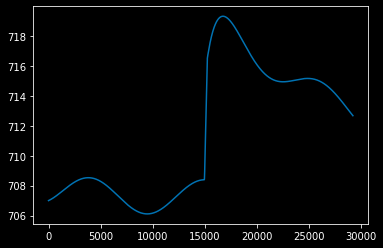

In [62]:
# pyplot.plot(wtf[:, 1])
pyplot.plot(solution)

In [65]:
bin_data(solution, data[0], growth, oversample)

DeviceArray([707.20387276, 707.73864381, 708.24302927, 708.51260365,
             708.4364159 , 708.02303576, 707.3933775 , 706.74002665,
             706.26487325, 706.11433477, 706.33248289, 706.84682369,
             707.49117761, 708.05835639, 708.36589055, 717.87373059,
             719.30292961, 718.84280169, 717.67940149, 716.46653212,
             715.55187006, 715.06237691, 714.95288641, 715.05946158,
             715.16687904, 715.08140152, 714.69185416, 714.0025773 ],            dtype=float64)

In [53]:
arrrgh = thing1.bin_data(wtf[:, 1], thing2.oversample, thing2.annual, thing2.growth)

In [57]:
omg = thing2.dc14_fine(parameters)

In [58]:
thing1.bin_data(omg, thing2.oversample, thing2.annual, thing2.growth)

DeviceArray([-23.18702678, -22.26462746, -21.4520851 , -21.00739259,
             -21.07174533, -21.62470968, -22.49071097, -23.39478087,
             -24.04986375, -24.24796085, -23.92617283, -23.18667119,
             -22.26425735, -21.45180998, -21.0072918 ,  -7.85016167,
              -5.88115795,  -6.53023936,  -8.15218341,  -9.83694077,
             -11.09928813, -11.76233551, -11.8908482 , -11.71676804,
             -11.54424287, -11.64692426, -12.18168289, -13.14204168],            dtype=float64)

In [54]:
arrrgh

DeviceArray([707.35639183, 707.35639183, 707.35639183, 707.35639183,
             707.35639183, 707.35639183, 707.35639183, 707.35639183,
             707.35639183, 707.35639183, 707.35639183, 707.35639183,
             707.35639183, 707.35639183, 707.35639183, 707.35639183,
             707.35639183, 707.35639183, 707.35639183, 707.35639183,
             707.35639183, 707.35639183, 707.35639183, 707.35639183,
             707.35639183, 707.35639183, 707.35639183, 707.35639183],            dtype=float64)

In [ ]:
@jax.tree_util.Partial
@jax.jit
def log_likelihood(args, /, data=data, func=solve, y0=STEADY_STATE):
    solution = func(y0, data[0], args)
    solution = (solution - STEADY_STATE[1]) / STEADY_STATE[1]
    solution += jax.numpy.mean(data[1][:4])
    chi_squared = (solution - data[1]) ** 2 / data[2] ** 2
    return - 0.5 * jax.numpy.sum(chi_squared)
    

In [ ]:
thing2.growth

DeviceArray([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float64)

In [ ]:
log_likelihood(parameters)

DeviceArray(-397.78775581, dtype=float64)

In [ ]:
%%timeit
log_likelihood(parameters)

476 µs ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
jac = jax.jit(jax.jacobian(log_likelihood))

In [ ]:
jac(parameters)

(DeviceArray(-1.00546032, dtype=float64, weak_type=True),
 DeviceArray(-0.48309617, dtype=float64, weak_type=True),
 DeviceArray(-0.02440878, dtype=float64, weak_type=True),
 DeviceArray(0.1201897, dtype=float64, weak_type=True))

In [ ]:
%%timeit
jac(parameters)

4.77 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
hes = jax.jit(jax.hessian(log_likelihood))

In [ ]:
%%timeit
hes(parameters)

44.7 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
